[View in Colaboratory](https://colab.research.google.com/github/PGrabinski/XRayPneumonia/blob/master/X_Ray.ipynb)

# Chest X-Ray images dataset
### Pneumonia detection model

Dataset taken from [Kaggle Datasets: Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia).

The dataset contains 5683 X-Ray images divided into two classes: *normal* and *pneumonia*.
With addition that the pneumonia can be caused either by bacteria or by viruses what changes the pictured tissues in two different ways.

![Chest X-Ray examples](https://i.imgur.com/jZqpV51.png)



In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
def downloadFilesFromFolderByID(folder_id, folder_name):
  import os, sys
  os.makedirs(os.path.join(folder_name, 'normal'), exist_ok=True)
  os.makedirs(os.path.join(folder_name, 'virus'), exist_ok=True)
  os.makedirs(os.path.join(folder_name, 'bacteria'), exist_ok=True)
  listed = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  for i, file in enumerate(listed):
    file = drive.CreateFile({'id':file['id']})
    file_path = folder_name + '/'
    if 'virus' in file['title']:
      file_path += 'virus/virus{}'.format(i)
    elif 'bacteria' in file['title']:
      file_path += 'bacteria/bacteria{}'.format(i)
    else:
      file_path += 'normal/normal{}'.format(i)
    file.GetContentFile('{}.jpg'.format(file_path))

In [0]:
folders_to_download = [
    {'id': '1EbT3bes4ONvGQvfI9oI_d-kmV42vYsU_', 'name': 'test'}, #NORMAL
    {'id': '1jerX6X-ugSY8KqNbDO6hDOdarncp-8Di', 'name': 'test'}, #PNEUMONIA
    {'id': '1onNxF1RQ6Eex7snIs2NPFuO7qcFLGb_c', 'name': 'train'}, #NORMAL
    {'id': '1pXT_pdjWjHNJ5JleOD0dTviafaUWfSGF', 'name': 'train'}, #PNEUMONIA
    {'id': '17uxXFRZ7fvnxWaLUgZK68836YgMUHF7O', 'name': 'val'}, #NORMAL
    {'id': '1VQgblsT_pvpkb6GfjjS2f6gX-usLDKxv', 'name': 'val'}, #PNEUMONIA
]

In [46]:
for folder in folders_to_download:
  downloadFilesFromFolderByID(folder['id'], folder['name'])

ApiRequestError: ignored

In [0]:
downloadFilesFromFolderByID(folders_to_download[2]['id'], folders_to_download[2]['name'])
downloadFilesFromFolderByID(folders_to_download[4]['id'], folders_to_download[4]['name'])
downloadFilesFromFolderByID(folders_to_download[5]['id'], folders_to_download[5]['name'])

In [10]:
!ls -R

.:
datalab  test  train

./datalab:
adc.json

./test:
bacteria  normal  virus

./test/bacteria:
bacteria101.jpg  bacteria178.jpg  bacteria279.jpg  bacteria351.jpg
bacteria102.jpg  bacteria182.jpg  bacteria280.jpg  bacteria353.jpg
bacteria105.jpg  bacteria185.jpg  bacteria281.jpg  bacteria355.jpg
bacteria106.jpg  bacteria186.jpg  bacteria282.jpg  bacteria358.jpg
bacteria107.jpg  bacteria188.jpg  bacteria283.jpg  bacteria359.jpg
bacteria108.jpg  bacteria190.jpg  bacteria284.jpg  bacteria360.jpg
bacteria110.jpg  bacteria194.jpg  bacteria285.jpg  bacteria361.jpg
bacteria111.jpg  bacteria196.jpg  bacteria286.jpg  bacteria362.jpg
bacteria112.jpg  bacteria197.jpg  bacteria287.jpg  bacteria363.jpg
bacteria114.jpg  bacteria198.jpg  bacteria288.jpg  bacteria365.jpg
bacteria116.jpg  bacteria202.jpg  bacteria291.jpg  bacteria366.jpg
bacteria117.jpg  bacteria203.jpg  bacteria292.jpg  bacteria36.jpg
bacteria118.jpg  bacteria205.jpg  bacteria293.jpg  bacteria371.jpg
bacteria119.jpg  bacteria206.jpg  

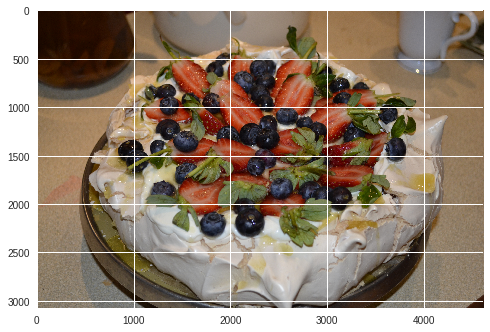

In [27]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
img = mpimg.imread('beza/normal/normal10.jpg')
plt.imshow(img)

In [12]:
from keras.preprocessing.image import ImageDataGenerator
import os

trainDatagen = ImageDataGenerator( rescale = 1./255)

testDatagen = ImageDataGenerator( rescale = 1./255 )

base_dir = ''
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

trainGen = trainDatagen.flow_from_directory(train_dir, target_size = (300, 300),
                                            batch_size = 32, class_mode = 'categorical') 
valGen = testDatagen.flow_from_directory(val_dir, target_size = (300, 300),
                                            batch_size = 32, class_mode = 'categorical') 
testGen = testDatagen.flow_from_directory(test_dir, target_size = (300, 300),
                                            batch_size = 32, class_mode = 'categorical')

Found 5216 images belonging to 3 classes.
Found 48 images belonging to 3 classes.
Found 592 images belonging to 3 classes.


In [82]:
import os

path, dirs, files = next(os.walk("train/virus"))
file_count = len(files)
print(file_count)

1345


In [65]:
1092+632+1341 # train

3065

In [67]:
218+16

234

In [71]:
234+140

374

In [0]:
3875/25

In [88]:
from keras import models
from keras import layers

model1 = models.Sequential()
model1.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(300,300,3)))
model1.add(layers.MaxPooling2D((2,2)))
model1.add(layers.Conv2D(64, (3,3), activation='relu'))
model1.add(layers.MaxPooling2D((2,2)))
model1.add(layers.Conv2D(128, (3,3), activation='relu'))
model1.add(layers.MaxPooling2D((2,2)))
model1.add(layers.Conv2D(128, (3,3), activation='relu'))
model1.add(layers.MaxPooling2D((2,2)))
model1.add(layers.Flatten())
model1.add(layers.Dense(512, activation='relu'))
model1.add(layers.Dense(3, activation='softmax'))
model1.summary()
model1.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics=['acc'])
history1 = model1.fit_generator(trainGen, steps_per_epoch = 163, epochs = 30, validation_data=valGen, validation_steps = 50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 35, 35, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 33, 33, 128)       147584    
__________

163/163 [==============================] - 82s 500ms/step - loss: 0.8633 - acc: 0.6670 - val_loss: 0.9372 - val_acc: 0.7083
Epoch 2/30
163/163 [==============================] - 78s 476ms/step - loss: 0.5352 - acc: 0.7772 - val_loss: 0.9658 - val_acc: 0.6875
Epoch 3/30
158/163 [============================>.] - ETA: 1s - loss: 0.4600 - acc: 0.8028

163/163 [==============================] - 78s 478ms/step - loss: 0.4657 - acc: 0.7998 - val_loss: 0.7695 - val_acc: 0.7500
Epoch 4/30
163/163 [==============================] - 78s 477ms/step - loss: 0.4307 - acc: 0.8127 - val_loss: 1.1441 - val_acc: 0.6875
Epoch 5/30
163/163 [==============================] - 78s 480ms/step - loss: 0.3894 - acc: 0.8290 - val_loss: 0.9812 - val_acc: 0.7083
Epoch 6/30
 13/163 [=>............................] - ETA: 34s - loss: 0.3205 - acc: 0.8726

163/163 [==============================] - 77s 474ms/step - loss: 0.3457 - acc: 0.8495 - val_loss: 1.1345 - val_acc: 0.7708
Epoch 7/30
163/163 [==============================] - 78s 477ms/step - loss: 0.3124 - acc: 0.8692 - val_loss: 1.6809 - val_acc: 0.5625
Epoch 8/30
149/163 [==========================>...] - ETA: 5s - loss: 0.2614 - acc: 0.8891

163/163 [==============================] - 78s 477ms/step - loss: 0.2624 - acc: 0.8890 - val_loss: 1.1396 - val_acc: 0.7292
Epoch 9/30
163/163 [==============================] - 77s 475ms/step - loss: 0.2047 - acc: 0.9166 - val_loss: 1.4404 - val_acc: 0.7708
Epoch 10/30
163/163 [==============================] - 77s 475ms/step - loss: 0.1635 - acc: 0.9352 - val_loss: 1.7603 - val_acc: 0.8125
Epoch 11/30
 11/163 [=>............................] - ETA: 34s - loss: 0.0726 - acc: 0.9716

163/163 [==============================] - 77s 475ms/step - loss: 0.1213 - acc: 0.9526 - val_loss: 2.3940 - val_acc: 0.7083
Epoch 12/30
163/163 [==============================] - 78s 476ms/step - loss: 0.1074 - acc: 0.9626 - val_loss: 2.5588 - val_acc: 0.7708
Epoch 13/30
148/163 [==========================>...] - ETA: 5s - loss: 0.0871 - acc: 0.9704

163/163 [==============================] - 77s 474ms/step - loss: 0.0889 - acc: 0.9709 - val_loss: 3.1181 - val_acc: 0.6458
Epoch 14/30
163/163 [==============================] - 77s 470ms/step - loss: 0.0775 - acc: 0.9749 - val_loss: 2.6977 - val_acc: 0.7292
Epoch 15/30
163/163 [==============================] - 78s 477ms/step - loss: 0.0698 - acc: 0.9799 - val_loss: 2.8624 - val_acc: 0.7708
Epoch 16/30
 10/163 [>.............................] - ETA: 34s - loss: 0.0496 - acc: 0.9812

163/163 [==============================] - 77s 473ms/step - loss: 0.0529 - acc: 0.9824 - val_loss: 2.5218 - val_acc: 0.7708
Epoch 17/30
163/163 [==============================] - 78s 476ms/step - loss: 0.0615 - acc: 0.9835 - val_loss: 3.1387 - val_acc: 0.7292
Epoch 18/30
147/163 [==========================>...] - ETA: 5s - loss: 0.0357 - acc: 0.9889

163/163 [==============================] - 78s 476ms/step - loss: 0.0403 - acc: 0.9875 - val_loss: 2.4885 - val_acc: 0.7708
Epoch 19/30
163/163 [==============================] - 78s 476ms/step - loss: 0.0425 - acc: 0.9875 - val_loss: 3.2068 - val_acc: 0.7708
Epoch 20/30
163/163 [==============================] - 78s 476ms/step - loss: 0.0360 - acc: 0.9923 - val_loss: 3.1964 - val_acc: 0.6875
Epoch 21/30
 10/163 [>.............................] - ETA: 34s - loss: 0.0257 - acc: 0.9906

163/163 [==============================] - 77s 475ms/step - loss: 0.0362 - acc: 0.9914 - val_loss: 2.8151 - val_acc: 0.7917
Epoch 22/30
163/163 [==============================] - 78s 476ms/step - loss: 0.0214 - acc: 0.9939 - val_loss: 2.7399 - val_acc: 0.8125
Epoch 23/30
147/163 [==========================>...] - ETA: 6s - loss: 0.0469 - acc: 0.9872

163/163 [==============================] - 78s 478ms/step - loss: 0.0428 - acc: 0.9885 - val_loss: 3.5147 - val_acc: 0.7083
Epoch 24/30
163/163 [==============================] - 78s 478ms/step - loss: 0.0313 - acc: 0.9933 - val_loss: 3.1471 - val_acc: 0.7292
Epoch 25/30
163/163 [==============================] - 78s 479ms/step - loss: 0.0449 - acc: 0.9904 - val_loss: 2.8808 - val_acc: 0.7292
Epoch 26/30
 10/163 [>.............................] - ETA: 34s - loss: 0.0034 - acc: 1.0000

163/163 [==============================] - 78s 476ms/step - loss: 0.0262 - acc: 0.9939 - val_loss: 2.8162 - val_acc: 0.7917
Epoch 27/30
163/163 [==============================] - 78s 479ms/step - loss: 0.0384 - acc: 0.9929 - val_loss: 2.8085 - val_acc: 0.7500
Epoch 28/30
147/163 [==========================>...] - ETA: 5s - loss: 0.0207 - acc: 0.9940

163/163 [==============================] - 78s 481ms/step - loss: 0.0191 - acc: 0.9944 - val_loss: 3.1465 - val_acc: 0.7500
Epoch 29/30
163/163 [==============================] - 78s 481ms/step - loss: 0.0229 - acc: 0.9948 - val_loss: 2.8842 - val_acc: 0.7708
Epoch 30/30
163/163 [==============================] - 78s 477ms/step - loss: 0.0256 - acc: 0.9935 - val_loss: 3.5058 - val_acc: 0.7500


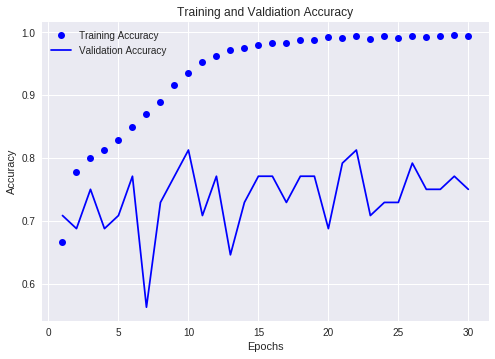

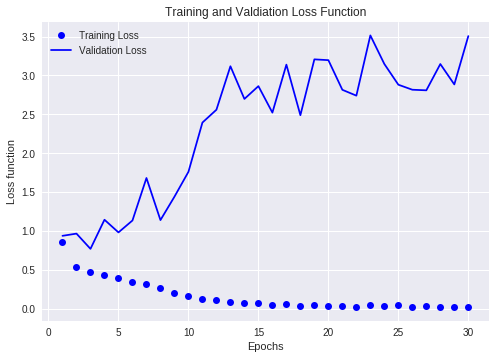

In [92]:
import matplotlib.pyplot as plt

acc1 = history1.history['acc']
val_acc1 = history1.history['val_acc']

loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']

epochs1 = range(1, 30 +1)

plt.plot(epochs1, acc1, 'bo', label='Training Accuracy')
plt.plot(epochs1, val_acc1, 'b', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Valdiation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs1, loss1, 'bo', label='Training Loss')
plt.plot(epochs1, val_loss1, 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.title('Training and Valdiation Loss Function')
plt.legend()

plt.show()

In [94]:
from keras import models
from keras import layers
from keras import optimizers

trainGen2 = trainDatagen.flow_from_directory(train_dir, target_size = (500, 500),
                                            batch_size = 32, class_mode = 'categorical') 
valGen2 = testDatagen.flow_from_directory(val_dir, target_size = (500, 500),
                                            batch_size = 32, class_mode = 'categorical') 
testGen2 = testDatagen.flow_from_directory(test_dir, target_size = (500, 500),
                                            batch_size = 32, class_mode = 'categorical')

model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(500,500,3)))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Conv2D(64, (3,3), activation='relu'))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Conv2D(128, (3,3), activation='relu'))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Conv2D(128, (3,3), activation='relu'))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(512, activation='relu'))
model2.add(layers.Dense(3, activation='softmax'))
model2.summary()
model2.compile(optimizer = optimizers.RMSprop(lr=1e-4), loss = 'categorical_crossentropy', metrics=['acc'])
history2 = model2.fit_generator(trainGen2, steps_per_epoch = 163, epochs = 30, validation_data=valGen2, validation_steps = 50)

Found 5216 images belonging to 3 classes.
Found 48 images belonging to 3 classes.
Found 592 images belonging to 3 classes.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 498, 498, 32)      896       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 249, 249, 32)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 247, 247, 64)      18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 123, 123, 64)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 121, 121, 128)     73856     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 60, 60, 128)       0         
___________________

163/163 [==============================] - 124s 762ms/step - loss: 0.7146 - acc: 0.6931 - val_loss: 0.7860 - val_acc: 0.7083
Epoch 2/30
163/163 [==============================] - 120s 734ms/step - loss: 0.5025 - acc: 0.7749 - val_loss: 0.8719 - val_acc: 0.6875
Epoch 3/30
155/163 [===========================>..] - ETA: 4s - loss: 0.4467 - acc: 0.8052

163/163 [==============================] - 120s 735ms/step - loss: 0.4467 - acc: 0.8064 - val_loss: 1.3834 - val_acc: 0.5000
Epoch 4/30
163/163 [==============================] - 120s 734ms/step - loss: 0.4179 - acc: 0.8137 - val_loss: 1.0883 - val_acc: 0.6458
Epoch 5/30
163/163 [==============================] - 120s 737ms/step - loss: 0.3811 - acc: 0.8313 - val_loss: 1.2121 - val_acc: 0.6875
Epoch 6/30
 11/163 [=>............................] - ETA: 1:33 - loss: 0.3683 - acc: 0.8466

163/163 [==============================] - 120s 736ms/step - loss: 0.3510 - acc: 0.8409 - val_loss: 1.5026 - val_acc: 0.6042
Epoch 7/30
163/163 [==============================] - 120s 738ms/step - loss: 0.3168 - acc: 0.8639 - val_loss: 1.2513 - val_acc: 0.6458
Epoch 8/30
147/163 [==========================>...] - ETA: 9s - loss: 0.2761 - acc: 0.8835 

163/163 [==============================] - 120s 737ms/step - loss: 0.2756 - acc: 0.8844 - val_loss: 1.4020 - val_acc: 0.6667
Epoch 9/30
163/163 [==============================] - 120s 737ms/step - loss: 0.2414 - acc: 0.8982 - val_loss: 1.5343 - val_acc: 0.6458
Epoch 10/30
163/163 [==============================] - 120s 737ms/step - loss: 0.1997 - acc: 0.9147 - val_loss: 1.9476 - val_acc: 0.6667
Epoch 11/30
  9/163 [>.............................] - ETA: 1:34 - loss: 0.1669 - acc: 0.9201

163/163 [==============================] - 120s 737ms/step - loss: 0.1644 - acc: 0.9327 - val_loss: 2.4426 - val_acc: 0.6250
Epoch 12/30
163/163 [==============================] - 120s 737ms/step - loss: 0.1259 - acc: 0.9536 - val_loss: 2.4358 - val_acc: 0.6458
Epoch 13/30
145/163 [=========================>....] - ETA: 11s - loss: 0.1159 - acc: 0.9560

163/163 [==============================] - 120s 736ms/step - loss: 0.1135 - acc: 0.9572 - val_loss: 2.5008 - val_acc: 0.6875
Epoch 14/30
163/163 [==============================] - 120s 738ms/step - loss: 0.0771 - acc: 0.9734 - val_loss: 2.5755 - val_acc: 0.6667
Epoch 15/30
163/163 [==============================] - 120s 736ms/step - loss: 0.0646 - acc: 0.9799 - val_loss: 3.1035 - val_acc: 0.6042
Epoch 16/30
  8/163 [>.............................] - ETA: 1:36 - loss: 0.1175 - acc: 0.9609

163/163 [==============================] - 120s 735ms/step - loss: 0.0503 - acc: 0.9841 - val_loss: 3.1514 - val_acc: 0.6667
Epoch 17/30
163/163 [==============================] - 120s 736ms/step - loss: 0.0454 - acc: 0.9847 - val_loss: 3.1571 - val_acc: 0.6042
Epoch 18/30
145/163 [=========================>....] - ETA: 11s - loss: 0.0344 - acc: 0.9920

163/163 [==============================] - 120s 736ms/step - loss: 0.0319 - acc: 0.9925 - val_loss: 3.2087 - val_acc: 0.6458
Epoch 19/30
163/163 [==============================] - 120s 737ms/step - loss: 0.0194 - acc: 0.9942 - val_loss: 3.4781 - val_acc: 0.6458
Epoch 20/30
163/163 [==============================] - 120s 734ms/step - loss: 0.0392 - acc: 0.9935 - val_loss: 3.4517 - val_acc: 0.7083
Epoch 21/30
  8/163 [>.............................] - ETA: 1:34 - loss: 9.1723e-04 - acc: 1.0000

163/163 [==============================] - 120s 737ms/step - loss: 0.0322 - acc: 0.9925 - val_loss: 3.0063 - val_acc: 0.6667
Epoch 22/30
163/163 [==============================] - 120s 735ms/step - loss: 0.0239 - acc: 0.9954 - val_loss: 3.1610 - val_acc: 0.6875
Epoch 23/30
145/163 [=========================>....] - ETA: 11s - loss: 0.0537 - acc: 0.9918

163/163 [==============================] - 120s 736ms/step - loss: 0.0480 - acc: 0.9927 - val_loss: 3.2226 - val_acc: 0.6667
Epoch 24/30
163/163 [==============================] - 120s 735ms/step - loss: 0.0327 - acc: 0.9941 - val_loss: 3.5684 - val_acc: 0.6667
Epoch 25/30
163/163 [==============================] - 120s 734ms/step - loss: 0.0090 - acc: 0.9962 - val_loss: 3.5771 - val_acc: 0.6875
Epoch 26/30
  7/163 [>.............................] - ETA: 1:35 - loss: 8.0831e-04 - acc: 1.0000

163/163 [==============================] - 120s 735ms/step - loss: 0.0162 - acc: 0.9965 - val_loss: 3.8398 - val_acc: 0.6875
Epoch 27/30
163/163 [==============================] - 120s 736ms/step - loss: 0.0207 - acc: 0.9954 - val_loss: 3.8650 - val_acc: 0.7083
Epoch 28/30
144/163 [=========================>....] - ETA: 11s - loss: 0.0417 - acc: 0.9946

163/163 [==============================] - 120s 734ms/step - loss: 0.0369 - acc: 0.9952 - val_loss: 3.8345 - val_acc: 0.6458
Epoch 29/30
163/163 [==============================] - 120s 735ms/step - loss: 0.0150 - acc: 0.9969 - val_loss: 3.7026 - val_acc: 0.6667
Epoch 30/30
163/163 [==============================] - 119s 733ms/step - loss: 0.0619 - acc: 0.9942 - val_loss: 3.8211 - val_acc: 0.6458


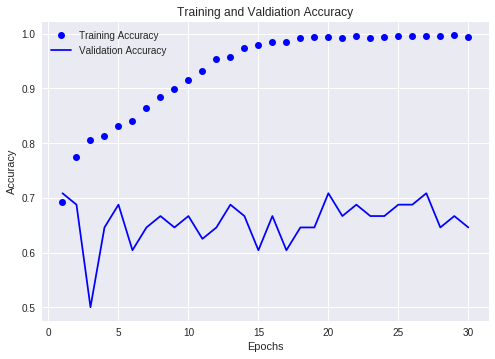

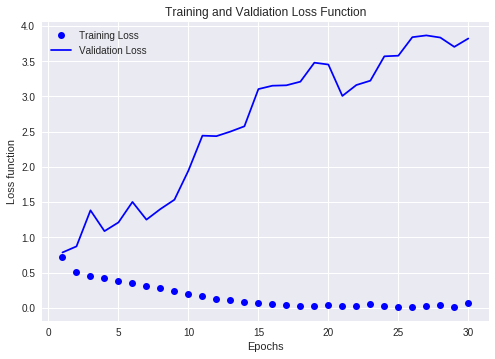

In [96]:
import matplotlib.pyplot as plt

acc2 = history2.history['acc']
val_acc2 = history2.history['val_acc']

loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs2 = range(1, 30 +1)

plt.plot(epochs2, acc2, 'bo', label='Training Accuracy')
plt.plot(epochs2, val_acc2, 'b', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Valdiation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs2, loss2, 'bo', label='Training Loss')
plt.plot(epochs2, val_loss2, 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.title('Training and Valdiation Loss Function')
plt.legend()

plt.show()

In [13]:
from keras import models
from keras import layers
from keras import optimizers

trainGen3 = trainDatagen.flow_from_directory(train_dir, target_size = (1000, 700),
                                            batch_size = 32, class_mode = 'categorical') 
valGen3 = testDatagen.flow_from_directory(val_dir, target_size = (1000, 700),
                                            batch_size = 32, class_mode = 'categorical') 
testGen2 = testDatagen.flow_from_directory(test_dir, target_size = (1000, 700),
                                            batch_size = 32, class_mode = 'categorical')

model3 = models.Sequential()
model3.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(1000, 700, 3)))
model3.add(layers.MaxPooling2D((2,2)))
model3.add(layers.Conv2D(64, (3,3), activation='relu'))
model3.add(layers.MaxPooling2D((2,2)))
model3.add(layers.Conv2D(128, (3,3), activation='relu'))
model3.add(layers.MaxPooling2D((2,2)))
model3.add(layers.Conv2D(128, (3,3), activation='relu'))
model3.add(layers.MaxPooling2D((2,2)))
model3.add(layers.Flatten())
model3.add(layers.Dense(512, activation='relu'))
model3.add(layers.Dense(3, activation='softmax'))
model3.summary()
model3.compile(optimizer = optimizers.RMSprop(lr=1e-5), loss = 'categorical_crossentropy', metrics=['acc'])
history3 = model3.fit_generator(trainGen3, steps_per_epoch = 163, epochs = 40, validation_data=valGen3, validation_steps = 50)

Found 5216 images belonging to 3 classes.
Found 48 images belonging to 3 classes.
Found 592 images belonging to 3 classes.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 998, 698, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 499, 349, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 497, 347, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 248, 173, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 246, 171, 128)     73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 123, 85, 128)      0         
___________________

ResourceExhaustedError: ignored